In [1]:
from sleap_roots.convhull import get_convhull, get_chull_area, get_chull_division_areas, get_chull_areas_via_intersection, get_chull_area_via_intersection_above, get_chull_area_via_intersection_below
from sleap_roots.points import get_nodes, get_line_equation_from_points
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely import box, LineString, normalize, Polygon, intersection, Point, MultiPoint
from typing import List, Tuple, Optional


In [2]:
pts = np.array(
        [
            [[-1, 0], [-1, 1], [-1, 2], [-1, 3], [-2, 4], [-3, 5]],
            [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5]],
            [[1, 0], [1, 1], [2, 2], [3, 3], [4, 4], [4, 5]],
        ]
    )

In [3]:
pts.shape

(3, 6, 2)

In [4]:
hull = get_convhull(pts)
hull

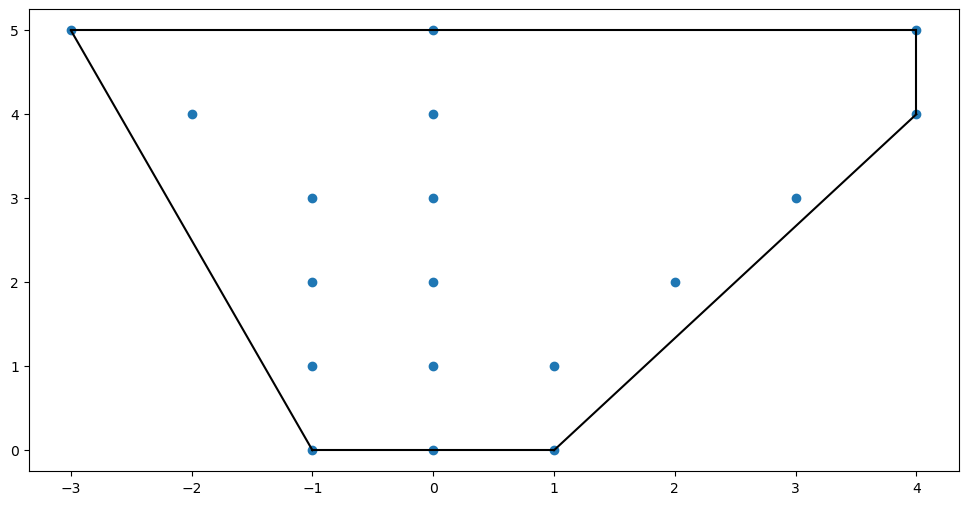

In [5]:
points = pts.reshape(-1, 2)

# plot convex hull of points 
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    ax.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'k-')

plt.show()

In [6]:
r1_pts = pts[:, 1, :]
r1_pts

array([[-1,  1],
       [ 0,  1],
       [ 1,  1]])

In [7]:
leftmost_r1 = r1_pts[np.argmin(r1_pts[:, 0])]
leftmost_r1

array([-1,  1])

In [8]:
rightmost_r1 = r1_pts[np.argmax(r1_pts[:, 0])]
rightmost_r1

array([1, 1])

In [9]:
m, b = get_line_equation_from_points(leftmost_r1, rightmost_r1)
m, b

(0.0, 1.0)

In [10]:
# Initialize lists to hold points above/on and below the line
above_or_on_line = []
below_line = []
# Classify each point as being above or below the line
for point in points:
    if point[1] <= m * point[0] + b:  # y <= mx + b (y increases downward in image coordinates)
        above_or_on_line.append(point)
    else:
        below_line.append(point)

In [11]:
above_or_on_line

[array([-1,  0]),
 array([-1,  1]),
 array([0, 0]),
 array([0, 1]),
 array([1, 0]),
 array([1, 1])]

In [12]:
below_line

[array([-1,  2]),
 array([-1,  3]),
 array([-2,  4]),
 array([-3,  5]),
 array([0, 2]),
 array([0, 3]),
 array([0, 4]),
 array([0, 5]),
 array([2, 2]),
 array([3, 3]),
 array([4, 4]),
 array([4, 5])]

In [13]:
# Find the leftmost and rightmost points of the convex hull
leftmost_pt = np.nanmin(points[:, 0])
rightmost_pt = np.nanmax(points[:, 0])

In [14]:
leftmost_pt, rightmost_pt

(-3, 4)

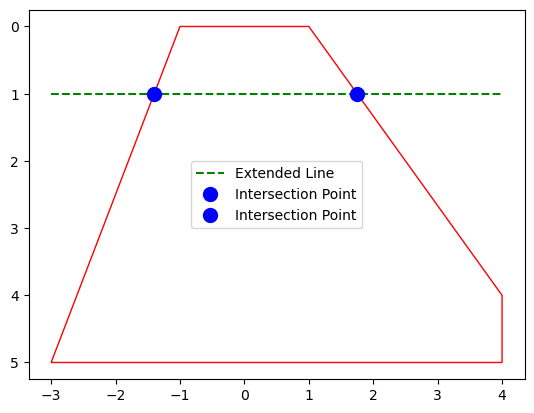

In [15]:
# Define how far you want to extend the line in terms of x
x_min_extended = leftmost_pt  # Far left point
x_max_extended = rightmost_pt   # Far right point

# Calculate the corresponding y-values using the line equation
y_min_extended = m * x_min_extended + b
y_max_extended = m * x_max_extended + b

# Create the extended line
extended_line = LineString([(x_min_extended, y_min_extended), (x_max_extended, y_max_extended)])

# Create a LineString that represents the perimeter of the convex hull
hull_perimeter = LineString(hull.points[hull.vertices].tolist() + [hull.points[hull.vertices[0]].tolist()])

# Find the intersection between the hull perimeter and the extended line
intersection = extended_line.intersection(hull_perimeter)

# Visualizing the intersection
fig, ax = plt.subplots()
x, y = zip(*hull.points[hull.vertices])
plt.fill(x, y, edgecolor='r', fill=False)  # Plot convex hull
x, y = extended_line.xy
plt.plot(x, y, 'g--', label='Extended Line')  # Plot extended line

# Plot intersection points
if not intersection.is_empty:
    if intersection.geom_type == 'Point':
        plt.plot(intersection.x, intersection.y, 'bo', markersize=10, label='Intersection Point')
    else:
        for point in intersection.geoms:
            plt.plot(point.x, point.y, 'bo', markersize=10, label='Intersection Point')

plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.legend()
plt.show()


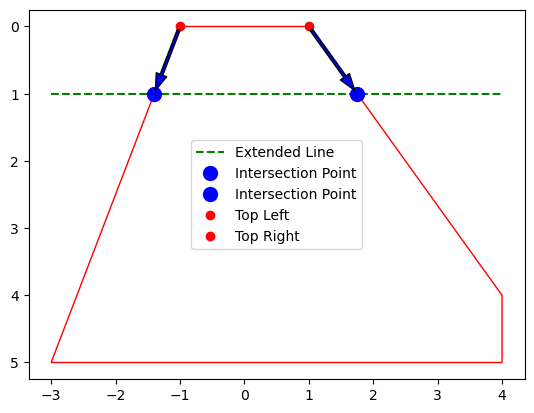

In [16]:
# Define how far you want to extend the line in terms of x
x_min_extended = leftmost_pt  # Far left point
x_max_extended = rightmost_pt   # Far right point

# Calculate the corresponding y-values using the line equation
y_min_extended = m * x_min_extended + b
y_max_extended = m * x_max_extended + b

# Create the extended line
extended_line = LineString([(x_min_extended, y_min_extended), (x_max_extended, y_max_extended)])

# Create a LineString that represents the perimeter of the convex hull
hull_perimeter = LineString(hull.points[hull.vertices].tolist() + [hull.points[hull.vertices[0]].tolist()])

# Find the intersection between the hull perimeter and the extended line
intersection = extended_line.intersection(hull_perimeter)

# Get the intersection points
if not intersection.is_empty:
    intersect_points = (
        np.array([[point.x, point.y] for point in intersection.geoms])
        if intersection.geom_type == "MultiPoint"
        else np.array([[intersection.x, intersection.y]])
    )
# Get the leftmost and rightmost intersection points
leftmost_intersect = intersect_points[np.argmin(intersect_points[:, 0])]
rightmost_intersect = intersect_points[np.argmax(intersect_points[:, 0])]

# Find the leftmost and rightmost r0 point
r0_pts = pts[:, 0, :]
r0_pts_valid = r0_pts[~np.isnan(r0_pts).any(axis=1)]
leftmost_r0 = r0_pts_valid[np.argmin(r0_pts_valid[:, 0])]
rightmost_r0 = r0_pts_valid[np.argmax(r0_pts_valid[:, 0])]

# Make a vector from the leftmost r0 point to the leftmost intersection point
leftmost_vector = leftmost_intersect - leftmost_r0
# Make a vector from the rightmost r0 point to the rightmost intersection point
rightmost_vector = rightmost_intersect - rightmost_r0

# Visualizing the intersection and the top left and right points
fig, ax = plt.subplots()
x, y = zip(*hull.points[hull.vertices])
plt.fill(x, y, edgecolor='r', fill=False)  # Plot convex hull
x, y = extended_line.xy
plt.plot(x, y, 'g--', label='Extended Line')  # Plot extended line

# Plot intersection points
if not intersection.is_empty:
    if intersection.geom_type == 'Point':
        plt.plot(intersection.x, intersection.y, 'bo', markersize=10, label='Intersection Point')
    else:
        for point in intersection.geoms:
            plt.plot(point.x, point.y, 'bo', markersize=10, label='Intersection Point')

# Plot top left and right points
plt.plot(leftmost_r0[0], leftmost_r0[1], 'ro', label='Top Left')
plt.plot(rightmost_r0[0], rightmost_r0[1], 'ro', label='Top Right')

# Draw vectors from r0 points to intersection points
# For the leftmost vector
ax.annotate('', xy=leftmost_intersect, xytext=leftmost_r0,
            arrowprops=dict(facecolor='blue', width=2, headwidth=8, shrink=0.05))
# For the rightmost vector
ax.annotate('', xy=rightmost_intersect, xytext=rightmost_r0,
            arrowprops=dict(facecolor='blue', width=2, headwidth=8, shrink=0.05))

plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.legend()
plt.show()


In [17]:
# Add the intersection points to the above_or_on_line list
for point in intersection.geoms:
    above_or_on_line.append(np.array([point.x, point.y]))

above_or_on_line

[array([-1,  0]),
 array([-1,  1]),
 array([0, 0]),
 array([0, 1]),
 array([1, 0]),
 array([1, 1]),
 array([-1.4,  1. ]),
 array([1.75, 1.  ])]

In [18]:
# Add the intersection points to the below_line list
for point in intersection.geoms:
    below_line.append(np.array([point.x, point.y]))

In [19]:
# Calculate areas using get_chull_area, return np.nan if no points satisfy the condition
area_above_line = (
    get_chull_area(np.array(above_or_on_line)) if above_or_on_line else np.nan
)
area_below_line = get_chull_area(np.array(below_line)) if below_line else np.nan

In [20]:
area_above_line, area_below_line

(2.5749999999999997, 21.424999999999997)

In [21]:
get_chull_area(hull)

24.0

In [22]:
area_above_line + area_below_line

23.999999999999996

C:\Users\Elizabeth_Berrigan\AppData\Local\Temp\ipykernel_33864\1040779169.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_vals, y_vals, 'r--', color='orange', label='Line: y = {:.2f}x + {:.2f}'.format(m, b))


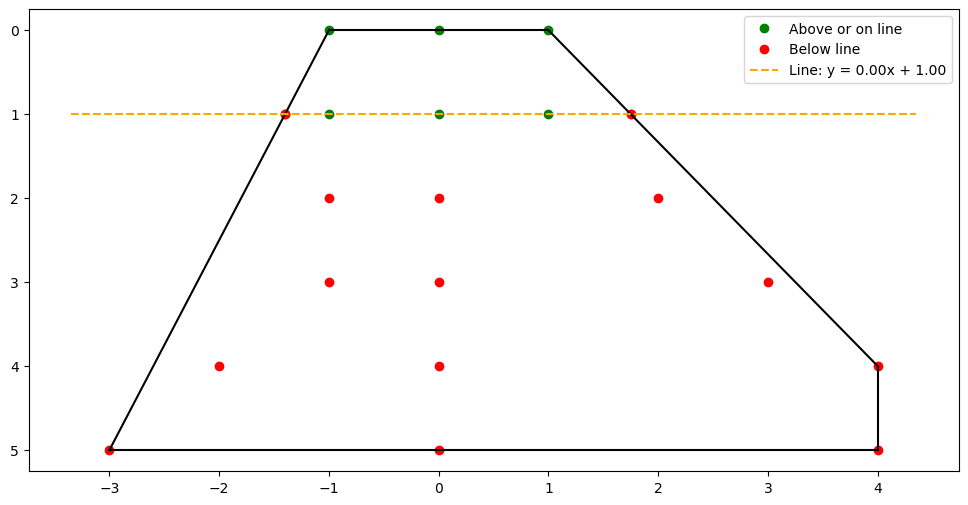

In [23]:
# x values for the line plot
x_vals = np.array(ax.get_xlim())
# y values based on the line equation y = mx + b
y_vals = m * x_vals + b

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot points
# ax.plot(points[:,0], points[:,1], 'o', label='Points')

# Plot points above or on the line
ax.plot(np.array(above_or_on_line)[:,0], np.array(above_or_on_line)[:,1], 'o', color='green', label='Above or on line')
# Plot points below the line
ax.plot(np.array(below_line)[:,0], np.array(below_line)[:,1], 'o', color='red', label='Below line')

# Plot convex hull
for simplex in hull.simplices:
    ax.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'k-')

# Plot line
ax.plot(x_vals, y_vals, 'r--', color='orange', label='Line: y = {:.2f}x + {:.2f}'.format(m, b))

# Invert y axis to match image coordinates
ax.invert_yaxis()

# Legend
ax.legend()

plt.show()

In [25]:
get_chull_areas_via_intersection(pts[:, 1, :], pts, hull)

(2.5749999999999997, 21.424999999999997)

In [ ]:
# # Sample data points and hull
# pts = np.random.rand(30, 2) * 50  # 30 random points in 2-D
# hull = ConvexHull(pts)

# # Reshape points for plotting
# points = pts.reshape(-1, 2)

# # Sample line equation parameters
# m = 0.5  # slope
# b = 10  # y-intercept

# # x values for the line plot
# x_vals = np.array(ax.get_xlim())
# # y values based on the line equation y = mx + b
# y_vals = m * x_vals + b

# # Plotting
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot points
# ax.plot(points[:,0], points[:,1], 'o', label='Points')

# # Plot convex hull
# for simplex in hull.simplices:
#     ax.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'k-', label='Convex Hull')

# # Plot line
# ax.plot(x_vals, y_vals, 'r--', color='orange', label='Line: y = {:.2f}x + {:.2f}'.format(m, b))

# # Legend
# ax.legend()

# plt.show()